# How to integrate Financial Data from Refinitiv Data Platform to Excel with Xlwings - Part 1

## Overview

With the rise of Data Scientists, Financial coders or Traders (aka Citizen Developers), and the rapid growth of [Jupyter](https://jupyter.org/) application, the main target of every Citizen Developer is replacing [Microsoft Excel](https://www.microsoft.com/en-us/microsoft-365/excel) with the Jupyter application (reference: [Jupyter is the new Excel](https://towardsdatascience.com/jupyter-is-the-new-excel-a7a22f2fc13a)).

However, Excel is not obsolete and is still an important file-format/application for businesses. It is easy to distribute, and non-IT people (especially your boss) can open it easily rather than having to set up the Jupyter/Python environment.

This article is the first part of the series that demonstrate how to export financial data and report from Python/Jupyter application to Excel report file using xlwings CE and xlwings Pro libraries. The demo application uses content from [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-apis) as an example of  a dataset.

This first notebook will be focusing on xlwings CE. The [second notebook](./part2_xlwings_pro_notebook.ipynb) is focusing on xlwings PRO.

*Note*: All figures and reports demonstrate Time-Series 90 days data queried on 14th October 2020.

## Introduction to xlwings

[xlwings](https://www.xlwings.org) is a Python library that makes it easy to call Python from Excel and vice versa on Windows and macOS. The library lets you automate Excel from Python source code to produce reports or to interact with Jupyter notebook applications. It also allows you to replace VBA macros with Python Code or write UDFs (user defined functions - Windows only).
* The [xlwings CE](https://docs.xlwings.org/en/stable) is a free and open-source library ([BSD-licensed](https://opensource.org/licenses/BSD-3-Clause)) which provides basic functionalities to lets developers integrate Python with Excel. 
* The [xlwings PRO](https://www.xlwings.org/pro) provides more advance features such as [reports](https://www.xlwings.org/reporting), embedded Python code in Excel, one-click installers for easy deployment, video training, dedicated support and much more. 
 

*Note*:
- This notebook is based on xlwings versions **0.20.7**, **0.21.0** and **0.21.2**.


## Introduction to Refinitiv Data Platform (RDP) Libraries

Refinitiv provides a wide range of contents and data which require multiple technologies, delivery mechanisms, data formats, and the multiple APIs to access each content. The [RDP Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) are a suite of ease-of-use interfaces providing unified access to streaming and non-streaming data services offered within the [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis). The Libraries simplified how to access data to various delivery modes such as Request Response, Streaming, Bulk File, and Queues via a single library. 

Depending on the level of service and data requirements, developers can easily choose how to access data services using the appropriate access channel defined within the library.

![Figure-1](images/rdp_libraries_1.png "RDP Libraries Diagram") 

Using the library developers can access content from all 3 of the access points - all from within the same application if required. The RDP Libraries are available in the following programming languages:
- Refinitiv Supported Editions: Python and TypeScript/JavaScript (coming in 2020)
- Community-based Edition: C#

For more deep detail regarding the RDP Libraries, please refer to the following articles and tutorials:
- [Developer Article: Discover our Refinitiv Data Platform Library part 1](https://developers.refinitiv.com/article/discover-our-upcoming-refinitiv-data-platform-library-part-1).
- [Developer Article: Discover our Refinitiv Data Platform Library part 2](https://developers.refinitiv.com/article/discover-our-upcoming-refinitiv-data-platform-library-part-2-0).
- [Refinitiv Data Platform Libraries Document: An Introduction page](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-libraries/docs?content=62446&type=documentation_item).

### Disclaimer

As this notebook is based on alpha versions **1.0.0.a5** and **1.0.0.a7** of the Python library, the method signatures, data formats, etc. are subject to change.

## Code Walkthrough

Let start with xlwings CE first. The application needs to import ```xlwings``` and ```refinitiv.dataplatform``` packages in order to interact with xlwings CE and RDP library.

In [1]:
# import xlwings and RDP libraries
import xlwings as xw
import refinitiv.dataplatform as rdp

In [2]:
# import all required libraries for this notebook
import datetime
import configparser as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tick
import json

You should save a text file with **filename** `rdp.cfg` having the following contents:

    [rdp]
    username = YOUR_RDP_EMAIL_USERNAME
    password = YOUR_RDP_PASSWORD
    app_key = YOUR_RDP_APP_KEY
    
This file should be readily available (e.g. in the current working directory) for the next steps.

In [3]:
cfg = cp.ConfigParser()
cfg.read('rdp.cfg')

['rdp.cfg']

The RDP Libraries let application consumes data from the following platforms
- DesktopSession (Eikon/Refinitiv Workspace)
- PlatformSession (RDP, Refinitiv Real-Time Optimized)
- DeployedPlatformSession (deployed Refinitiv Real-Time/ADS)

This Jupyter Notebook is focusing on the *PlatformSession* only. However, the main logic for other session types are the same when interacts with xlwings library.

In [4]:
# Open RDP Platform Session
session = rdp.open_platform_session(
    cfg['rdp']['app_key'], 
    rdp.GrantPassword(
        username = cfg['rdp']['username'], 
        password = cfg['rdp']['password']
    )
)
session.get_open_state()

<State.Open: 3>

Firstly, we will use RDP Libraries Function Layer to request time-series data as a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object. 

In [7]:
# Declare parameter(s)
universe = 'VOD.L'
historical_title = '%s Historical Data' % (universe)

In [8]:
df_historical = rdp.get_historical_price_summaries(
    universe = universe,
    interval = rdp.Intervals.DAILY,
    count = 90,
    fields = ['BID','ASK','OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1','NUM_MOVES']
    )
df_historical

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
2020-06-10,136.26,136.28,138.02,138.64,135.28,136.7481,18794
2020-06-11,125.84,125.94,131.48,132.38,125.94,126.6638,19040
2020-06-12,126.08,126.1,124.66,127.9,122.24,126.1,16595
2020-06-15,124.44,124.46,123.76,125.06,122.7,124.46,13748
2020-06-16,129.1,129.12,126.94,130.56,126.2,128.98286,14998
...,...,...,...,...,...,...,...
2020-10-08,111.22,111.24,109.36,112.54,108.96,111.76,11804
2020-10-09,111.16,111.18,111.86,111.92,110.54,111.5405,7216
2020-10-12,111.84,111.86,111.68,113.4,111.5,112.3,9166
2020-10-13,111.98,112,112.74,113.52,111.48,112.74,11469


### Interact with xlwings CE

With xlwings, we can export this ```df_historical``` DataFrame to excel directly.

The first step is initiate xlwings object and establish a connection to a workbook.

In [9]:
wb = xw.Book() # Creating an new excel file. wb = xw.Book(filename) would open an existing file

The above step initiates xlwings workbook class in ```wb``` object. The ```wb = xw.Book()``` statement creates a new excel file. If you are using ```wb = xw.Book(filename)```, the xlwings will open an existing file.

![Figure-2](images/report_1.png "create a blank excel workbook") 

Next, instantiate the xlwings [sheet object](https://docs.xlwings.org/en/stable/api.html#sheet). The application will interact with Excel file mostly via this sheet object.


In [10]:
# Select the first excel sheet, and rename it

historical_sheet = wb.sheets[0]
historical_sheet.name = historical_title


![Figure-3](images/report_2_rename_sheet.png "rename workbook") 

Then you can just pass your dataframe object to ```sheet.range(<cell>).value``` property to set Pandas DataFrame to Excel directly.

In [11]:
# Set historical_sheet dataframe to cell A1

historical_sheet.range("A1").value = df_historical.head(30)


![Figure-4](images/report_3_dataframe.png "add data as is") 

That is, the application is ready to get and export Refinitiv Data to an Excel file.

The above example shows how to export data "as is" which often hard to read. The application can use xlwings API to customize excel report look and feel, and then customize Pandas DataFrame to make data easier to understand.

In [12]:
# Clear current sheet
historical_sheet.clear()

Then we use xlwings ```Sheet``` object and its ```api``` property to change report look and feel.

*Note*:
The xlwings ```api``` property supports Windows only. For MacOS, please refer to [this page](https://docs.xlwings.org/en/stable/missing_features.html).

In [13]:
historical_sheet.range("A1").value = historical_title
historical_sheet.range("A1").api.Font.Size = 14 # Change font size
historical_sheet.range("A1").api.Font.ColorIndex = 2 # Change font color
historical_sheet.range('A1:H1').color = (0,0,255) # Change cell background color

The above statements create the following excel  report look and feel.

![Figure-5](images/report_4.png "set title and header") 

We can restructure the ```df_historical``` DataFrame to make it easier to read by naming the index column to "Date"

In [14]:
df_historical.index.name = 'Date'
df_historical.head(5)

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
Date,,,,,,,
2020-06-10,136.26,136.28,138.02,138.64,135.28,136.7481,18794
2020-06-11,125.84,125.94,131.48,132.38,125.94,126.6638,19040
2020-06-12,126.08,126.1,124.66,127.9,122.24,126.1,16595
2020-06-15,124.44,124.46,123.76,125.06,122.7,124.46,13748
2020-06-16,129.1,129.12,126.94,130.56,126.2,128.98286,14998


Next, we set the DataFrame object to *A2* cell, then set column header font and background color to make them distinguish from data.

In [15]:
historical_sheet.range("A2").value = df_historical.head(30)

#Make Column headers bold
historical_sheet.range('2:1').api.Font.Bold = True
# Change cell background color
historical_sheet.range('A2:H2').color = (144,238,144) 
# Set sheet autofit the width of row
historical_sheet.autofit('r')

The result is the following readable report table:

![Figure-6](images/report_5.png "workbook with format") 

## Plotting a Graph

The xlwings CE also supports [Matplotlib](https://matplotlib.org/) figures in Excel as a picture.

Firstly, we change all non-Date columns data type from String to Float.

In [16]:
for column in df_historical:
    df_historical[column]=df_historical[column].astype(float)

 we change the DataFrame Date index to be a data column. This will let us plot a graph using **Date** as X-Axis.

In [17]:
df_historical.reset_index(level=0, inplace=True)
df_historical.head(5)

,Date,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
0,2020-06-10,136.26,136.28,138.02,138.64,135.28,136.74810,18794.0
1,2020-06-11,125.84,125.94,131.48,132.38,125.94,126.66380,19040.0
2,2020-06-12,126.08,126.10,124.66,127.90,122.24,126.10000,16595.0
3,2020-06-15,124.44,124.46,123.76,125.06,122.70,124.46000,13748.0
4,2020-06-16,129.10,129.12,126.94,130.56,126.20,128.98286,14998.0


Then sort data as ascending order.

In [41]:
# Sort DataFrame by Date
df_historical.sort_values('Date',ascending=True,inplace=True)

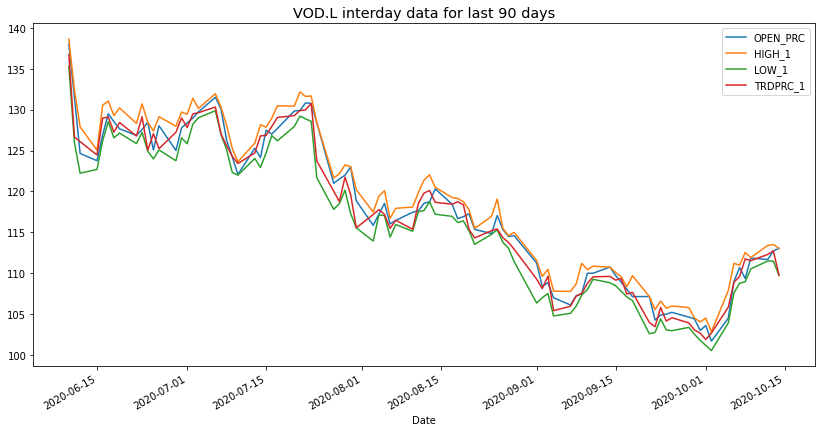

In [19]:
# Plotting a Graph

columns = ['OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1']

df_historical.set_index('Date',drop=True,inplace=True)
fig = plt.figure()


plt.ticklabel_format(style = 'plain')
plt.title('VOD.L interday data for last 90 days', color='black',fontsize='x-large')
ax = fig.gca()


df_historical.plot(kind='line', ax = fig.gca(),y=columns,figsize=(14,7) )
plt.show()

We will put this graph at the end of the report table in the Excel sheet. The application can check the position of the last row of the report table with xlwings [end()](https://docs.xlwings.org/en/0.20.5/api.html#xlwings.Range.end) function.

- The ```sheet.cells.last_cell``` statement returns lower right cell
- The ```sheet.cells.last_cell.row``` statement returns row of the lower right cell

In [20]:
# historical_sheet.cells.last_cell.row = row of the lower right cell

'''
change to your specified column, then go up until you hit a non-empty cell
'''
historical_last_row = historical_sheet.range((historical_sheet.cells.last_cell.row, 1)).end('up').row  
historical_last_row

#historical_last_row = historical_sheet.range('A' + str(historical_sheet.cells.last_cell.row)).end('up').row

32

Then, gets the position of the *last row of the table + 3 rows* cell. This makes a space between the data table and graph.

In [21]:
rng = historical_sheet.range('B{row}'.format(row = historical_last_row + 3))
rng

<Range [Book1]VOD.L Historical Data!$B$35>

Next, we add this figures as a picture to the xlwings CE sheet object with [pictures API](https://docs.xlwings.org/en/0.20.5/api.html#pictures).

In [22]:
historical_sheet.pictures.add(fig, name='MyPlot', update=True, top=rng.top, left=rng.left)

<Picture 'MyPlot' in <Sheet [Book1]VOD.L Historical Data>>

The result is the following readable report table:

![Figure-7](images/report_6.png "graph is ready") 

## Adding new Excel Sheet

We can create a new excel sheet and export data from RDP to that newly created sheet dynamically.

In [23]:
esg_sheet_title = '%s ESG Data' % (universe)
# Create new sheet for ESG Data
wb.sheets.add(esg_sheet_title)  

<Sheet [Book1]VOD.L ESG Data>

The above xlwings statement creates a new sheet in your excel workbook. 

![Figure-8](images/report_7.png "create new sheet") 

Then you can get this newly created sheet object and export data to it. I will demonstrate with Environment, Social, and Governance data (ESG) using RDP Delivery Layer.

In [24]:
# -- Requesting ESG Data

RDP_version = '/v1'
base_URL = 'https://api.refinitiv.com'

category_URL = '/data/environmental-social-governance'
service_endpoint_URL = '/views/scores-full'

query_parameters = {
    'universe': universe,
    'start': -5,
    'end': 0
}

In [25]:
endpoint_url = base_URL + category_URL + RDP_version + service_endpoint_URL #https://api.refinitiv.com/data/environmental-social-governance/v1/views/scores-full
try:
    endpoint = rdp.Endpoint(session, endpoint_url)
    response = endpoint.send_request( query_parameters = query_parameters )
    print('This is a ESG data result from RDP library')
    print(response.data.raw)
except Exception as exp:
	print('RDP Libraries: Delivery Layer exception: %s' % str(exp))

print('\n')

This is a ESG data result from RDP library
{'links': {'count': 6}, 'variability': 'variable', 'universe': [{'Instrument': 'VOD.L', 'Company Common Name': 'Vodafone Group PLC', 'Organization PermID': '4295896661', 'Reporting Currency': 'EUR'}], 'data': [['VOD.L', '2020-03-31', 44.88747570177, 82.0163307138848, 7.75862068965517, 70.9780764134787, 81.6693847197727, 90.978733378793, 81.6546762589928, 68.2835820895522, 61.8556701030927, 69.1176470588235, 91.9354838709677, 63.8235294117647, 93.167701863354, 98.9955357142857, 65.4017857142857, 89.2601431980906, 100, 'Grant Thornton UK LLP', '2020-09-18T00:00:00'], ['VOD.L', '2019-03-31', 46.7001752693279, 79.3652628193575, 14.0350877192982, 73.7984778671528, 84.3564939708211, 73.6229399178348, 88.6861313868613, 68.796992481203, 62.5, 78.6549707602339, 91.9354838709677, 64.6198830409356, 93.167701863354, 80.3769401330376, 41.2416851441241, 88.4248210023866, 100, 'Grant Thornton UK LLP', '2020-09-18T00:00:00'], ['VOD.L', '2018-03-31', 65.820888

The data returned from RDP Delivery layer is in JSON message format, so you need to convert it to Pandas DataFrame first.

In [27]:
titles = [i["title"] for i in response.data.raw['headers']]
esg_df = pd.DataFrame(response.data.raw['data'],columns=titles)

esg_df.head(3)

,Instrument,Period End Date,ESG Combined Score,ESG Score,ESG Controversies Score,Environment Pillar Score,Social Pillar Score,Governance Pillar Score,Resource Use Score,Emissions Score,...,Workforce Score,Human Rights Score,Community Score,Product Responsibility Score,Management Score,Shareholders Score,CSR Strategy Score,ESG Reporting Scope,ESG Report Auditor Name,ESG Period Last Update Date
0,VOD.L,2020-03-31,44.887476,82.016331,7.758621,70.978076,81.669385,90.978733,81.654676,68.283582,...,69.117647,91.935484,63.823529,93.167702,98.995536,65.401786,89.260143,100,Grant Thornton UK LLP,2020-09-18T00:00:00
1,VOD.L,2019-03-31,46.700175,79.365263,14.035088,73.798478,84.356494,73.622940,88.686131,68.796992,...,78.654971,91.935484,64.619883,93.167702,80.376940,41.241685,88.424821,100,Grant Thornton UK LLP,2020-09-18T00:00:00
2,VOD.L,2018-03-31,65.820889,80.451301,51.190476,71.166767,85.665270,77.112539,89.370079,60.546875,...,80.654762,92.543860,65.773810,94.585987,84.851936,42.938497,89.676617,100,KPMG LLP,2020-09-18T00:00:00


In [29]:
# initiate the xlwings sheet object]
esg_sheet = wb.sheets[esg_sheet_title]

#Set Sheet Title
esg_sheet.range("A1").value = 'VOD.L Environmental, Social and Governance Scores for last 5 years'
esg_sheet.range("A1").api.Font.Size = 14 # Change font size
esg_sheet.range("A1").api.Font.ColorIndex = 2 # Change font color
esg_sheet.range('A1:U1').color = (0,0,255) # Change cell background color

The result is following:

![Figure-9](images/report_8.png "set ESG sheet header") 

Then we export DataFrame ```esg_df``` object to ESG sheet ```esg_sheet``` object.

In [30]:
esg_sheet.range("A2").options(index=False).value = esg_df

esg_sheet.range('2:1').api.Font.Bold = True
esg_sheet.range('A2:U2').color = (144,238,144) # Change cell background color

![Figure-10](images/report_9.png "set ESG report data") 

Then we save this excel file with xlwings ```Book``` object ```save()``` function.

In [31]:
wb.save('rdp_report.xlsx') # Classic Jupyter Notebook

# wb.save() # Note: Somehow the Jupyter Lab is not allow overriden file as Classic Notebook.

## Reporting with xlwings PRO

The above example source code shows that you can create an excel report file from Refinitiv Data easily with xlwings CE API. However, the Python application source code is a combination of formatting the report's look & feel and handling the data which makes the source code difficult to maintain in the long run.

The [xlwings PRO ](https://www.xlwings.org/pro) has features to solve all of CE version limitations. The [xlwings Reports](https://www.xlwings.org/reporting) provides a capability to generate excel report file with the following features:
- **Separation of code and design**: Users without coding skills can change the template on their own without having to touch the Python code.
- **Template variables**: Python variables (between curly braces) can be directly used in cells, e.g. ```{{ title }}```. They act as placeholders that will be replaced by the actual values.
- **Frames for dynamic tables**: Frames are vertical containers that dynamically align and style tables that have a variable number of rows.

You can get a free trial for xlwings PRO [here](https://www.xlwings.org/pro), then follow the instruction on [How to activate xlwings PRO](https://docs.xlwings.org/en/stable/installation.html#how-to-activate-xlwings-pro) page.



Now let import the report package from xlwings PRO.


In [ ]:
# #uncomment if you do not already install xlwings PRO package.

# #Install xlwings PRO packages in a current Jupyter kernal
#import sys
#!{sys.executable} -m pip install "xlwings[pro]"

In [35]:
from xlwings.pro.reports import create_report

In [36]:
# Resize figure
# fig.set_size_inches(6.4, 4.8)

Then create an Excel template as a *rdp_report_template.xlsx* file with the following template format:

![Figure-11](images/report_10.png "excel report template") 

This template defines all look and feel (font, color, etc.) and also the position of auto generated data with a variable inside ```{{``` and ```}}```.

Then use the [report-api](https://docs.xlwings.org/en/stable/api.html#reports-api) to generate excel file based on a template file and data with ```create_report()``` function.

In [ ]:
wb = create_report(
    'rdp_report_template.xlsx', 
    'rdp_report_pro.xlsx', 
    historical_title=historical_title, 
    df_historical=df_historical.head(10), 
    graph= fig
)

The above ```create_report()``` function will generate *rdp_report_pro.xlsx* file with format defined in rdp_report_template.xlsx and data that we pass to the function.

![Figure-12](images/report_11.png "xlwings pro report result") 

The application does need to interact or hard code setting cells, sheets, and workbooks anymore. The xlwings PRO report package automatic replace ```{{ historical_title }}```, ```{{ df_historical }}``` and ```{{graph}}``` variables with data that the application pass through report package's ```create_report()``` function.

The application can pass text, DataFrame or even Graph to the function and xlwings will generate the excel report file based on the look and feel of the template file.

### Close RDP Session

In [38]:
# -- Close Session, just calls close_session() function

rdp.close_session()

print(session.get_open_state())

State.Closed


## Conclusion and Next Step

The xlwings CE library lets Python developers integrate data with Excel in a simple way. The library is suitable for a wide range of developers from casual coders, data scientists, professional traders to seasoned programmers, and allows them to work on data analysis and generate reports based on their skill. 

The next part will cover and show how powerful xlwings PRO is when comparing to CE library. Python developers' life will be easier with xlwings PRO.

At the same time, the [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-libraries) let developers rapidly access Refinitiv Platform content with a few lines of code that easy to understand and maintain. Developers can focus on implement the business logic or analysis data without worry about the connection, authentication detail with the Refinitiv Platforms.

The integration between Refinitiv APIs and xlwings is not limited to only RDP Libraries. Any [Refinitiv API](https://developers.refinitiv.com/en/api-catalog?i=1;q1=page-type%3Aapi;q2=devportal%3Alanguages~2Fpython;sort=title;sp_c=12;sp_cs=UTF-8;sp_k=devportal-prod;view=xml;x1=w-page-type-id;x2=api-language) that supports Python such as [Eikon Data API](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api) ([Eikon Data API-xlwings article](https://developers.refinitiv.com/en/article-catalog/article/financial-reporting-with-eikon-and-excel)), or [RKD API](https://developers.refinitiv.com/en/api-catalog/refinitiv-knowledge-direct/refinitiv-knowledge-direct-api-rkd-api) can work with xlwings using the same concept and code logic as this RDP Library notebook example. 


## References

You can find more details regarding the Refinitiv Data Platform Libraries, xlwings, and related technologies for this notebook from the following resources:
* [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) web site.
* [Xlwings web site](https://www.xlwings.org/).
* [Financial Reporting with Eikon, xlwings and Excel](https://developers.refinitiv.com/en/article-catalog/article/financial-reporting-with-eikon-and-excel).
* [Xlwings API Reference](https://docs.xlwings.org/en/stable/api.html).
* [Xlwings Document page](https://docs.xlwings.org/en/stable/).
* [RDP Libraries Quick Start Guide page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start).
* [RDP Libraries Tutorial page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/tutorials).
* [Discover our Refinitiv Data Platform Library (part 1)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-1).
* [Discover our Refinitiv Data Platform Library (part 2)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-2).

For any questions related to this article or Refinitiv Data Platform Libraries, please use the Developers Community [Q&A Forum](https://community.developers.refinitiv.com/spaces/321/refinitiv-data-platform-libraries.html).